In [98]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from google.colab import drive
from google.colab import files
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
from PIL import Image
import os


# 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы. (0.5 балла).

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import os

base_path = '/content/drive/MyDrive/ГО 2025/CV соревнование 1'
os.listdir(base_path)

['dl-2025-competition-1.zip', 'Transfer_learning_models.ipynb', '42.ipynb']

In [101]:
zip_path = '/content/drive/MyDrive/ГО 2025/CV соревнование 1/dl-2025-competition-1.zip'

In [102]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [103]:
base_path = '/content/data/'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Проверка наличия данных
print("Содержимое папки data:", os.listdir(base_path))
print("\nПример содержимого train:", os.listdir(train_path)[:5])

Содержимое папки data: ['train', 'test']

Пример содержимого train: ['66', '92', '29', '28', '86']


In [104]:
train_path

'/content/data/train'

## Сначала посмотрим на train

In [105]:
def analyze_class_distribution(data_path, dataset_name=''):
    try:
        class_counts = {}
        for class_name in sorted(os.listdir(data_path)):
            class_dir = os.path.join(data_path, class_name)
            if os.path.isdir(class_dir):
                count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
                if count > 0:
                    class_counts[class_name] = count

        plt.figure(figsize=(20, 8))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title(f'Class Distribution ({dataset_name})')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

        print(f"\nStatistics for {dataset_name}:")
        print(f"Total classes: {len(class_counts)}")
        print(f"Total images: {sum(class_counts.values())}")
        print(f"Min images per class: {min(class_counts.values())}")
        print(f"Max images per class: {max(class_counts.values())}")
        print(f"Mean: {np.mean(list(class_counts.values())):.1f}")
        print(f"Median: {np.median(list(class_counts.values()))}")

        return class_counts
    except Exception as e:
        print(f"Error analyzing {data_path}: {str(e)}")
        return {}



Analyzing training set...


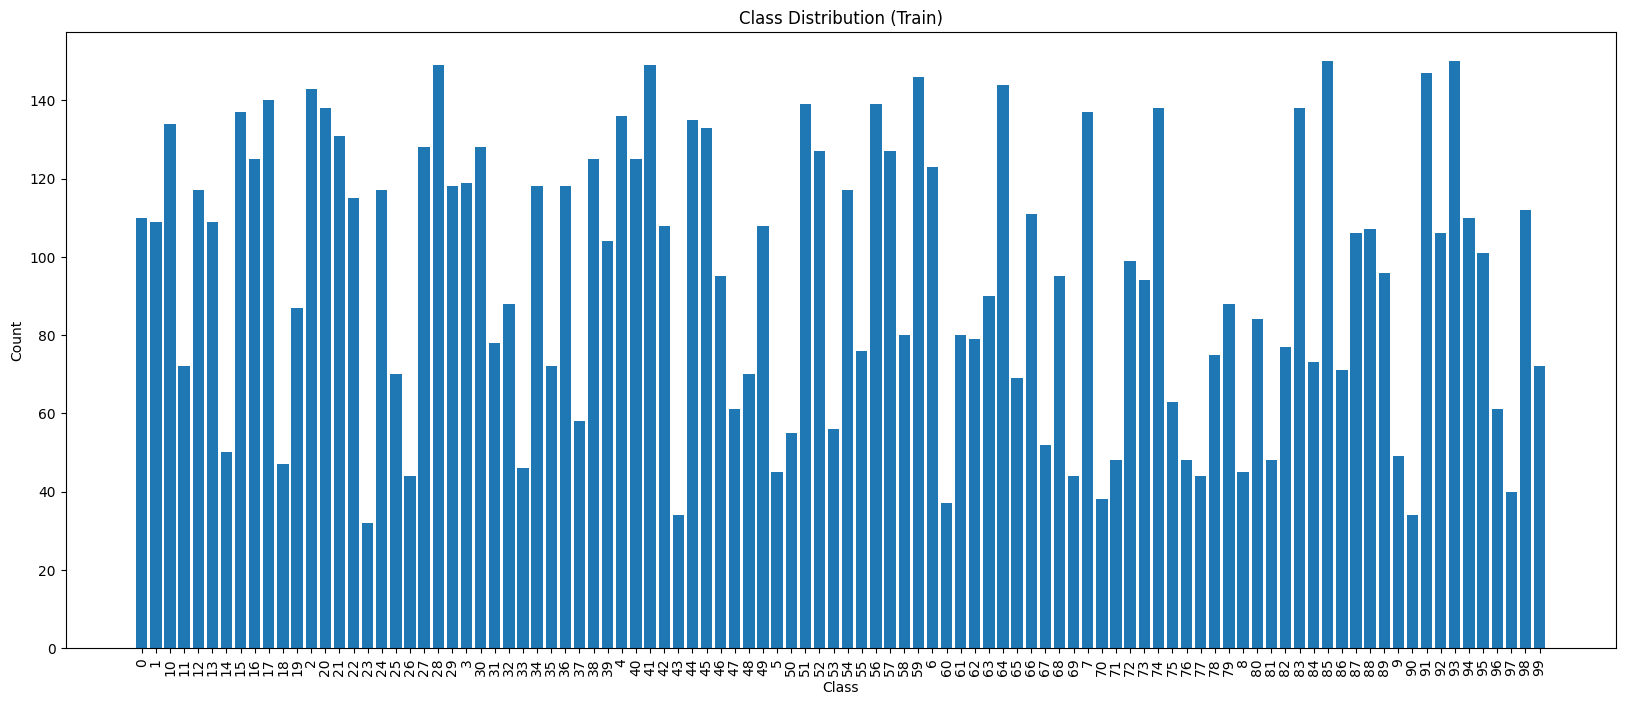


Statistics for Train:
Total classes: 100
Total images: 9510
Min images per class: 32
Max images per class: 150
Mean: 95.1
Median: 100.0


In [106]:
print("\nAnalyzing training set...")
train_counts = analyze_class_distribution(train_path, 'Train')
# print("\nAnalyzing test set...")
# test_counts = analyze_class_distribution(test_path, 'Test')

In [107]:
def show_100_random_class_samples(data_path):
    plt.figure(figsize=(10, 40))  # Широкое и высокое полотно

    classes = sorted(os.listdir(data_path), key=lambda x: int(x))[:100]

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, class_name)
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

        if not images:
            print(f"Класс {class_name} — нет изображений")
            continue

        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)

        try:
            img = Image.open(img_path)
            plt.subplot(20, 5, idx + 1)
            plt.imshow(img)
            plt.title(f'Class {class_name}')
            plt.axis('off')
        except Exception as e:
            print(f"Не удалось загрузить {img_path}: {e}")

    plt.tight_layout()
    plt.show()



Training set samples:


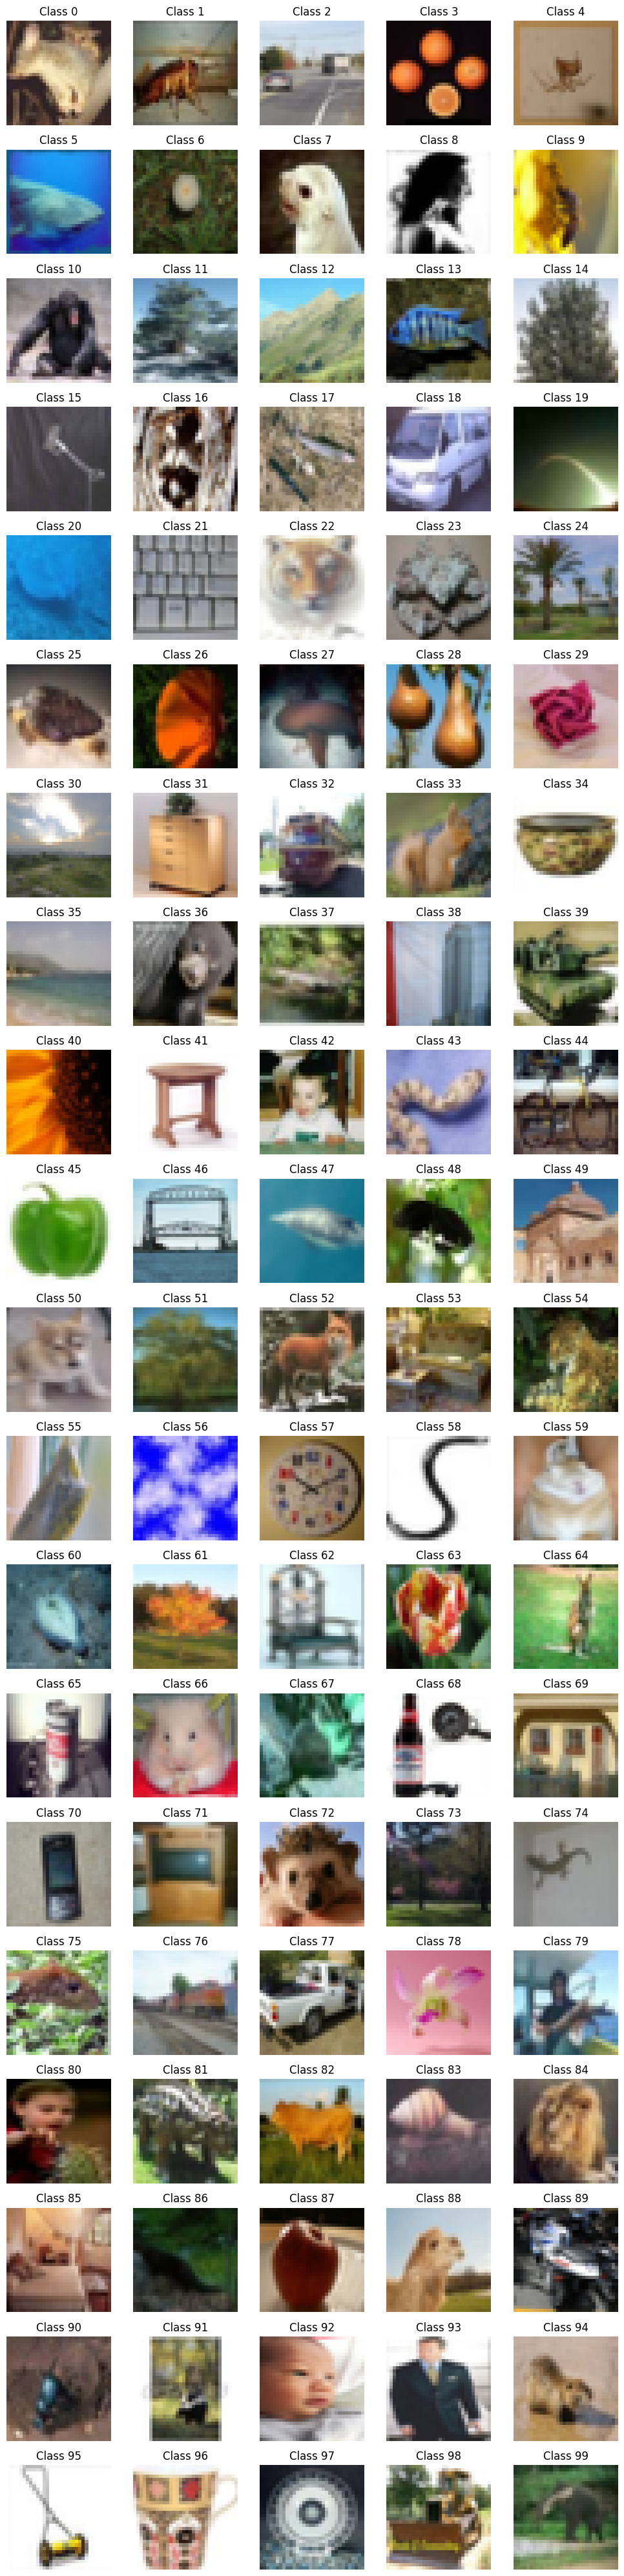

In [108]:
print("\nTraining set samples:")
show_100_random_class_samples(train_path)

## Посмотрим теперь на test

In [109]:
def show_test_samples(test_path, num_samples=15):
    plt.figure(figsize=(10, 5))  # Подходящий размер под 3x5

    images = [f for f in os.listdir(test_path)]
    if len(images) < num_samples:
        print("Недостаточно изображений в test-папке")
        return

    selected_images = random.sample(images, num_samples)

    for idx, img_name in enumerate(selected_images):
        img_path = os.path.join(test_path, img_name)

        try:
            img = Image.open(img_path)
            plt.subplot(3, 5, idx + 1)
            plt.imshow(img)
            plt.title(img_name)
            plt.axis('off')
        except Exception as e:
            print(f"Не удалось загрузить {img_path}: {e}")

    plt.tight_layout()
    plt.show()

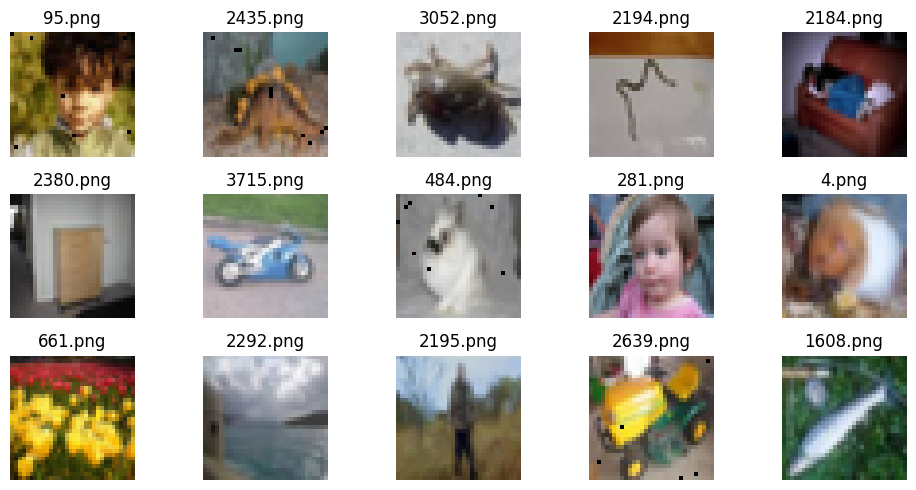

In [110]:
show_test_samples(test_path)

## Выводы:
1) Картинки достаточно плохого качества, по некоторым даже человеку трудно понять, что изображено \
2) Присутствует дисбаланс классов для примерно трети из них \
3) мало экземпляров для некоторых классов, требуется расширение датасета

# 2) Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель. (1.5 балла).

In [111]:
os.listdir(train_path + '/89')[:5]

['4549.png', '4611.png', '4532.png', '4588.png', '4538.png']

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

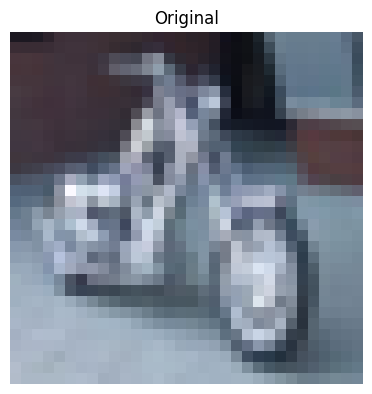

In [112]:
class_id = "89"
class_dir = os.path.join(train_path, class_id)

# img_name = random.choice(os.listdir(class_dir))
img_name = '4535.png'
img_path = os.path.join(class_dir, img_name)

image = Image.open(img_path).convert("RGB")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

In [113]:
image = np.array(image)

In [114]:
# transform = A.Compose([
#     A.AdditiveNoise(noise_type="uniform", spatial_mode="shared",
#                     approximation=1.0,
#                     p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [115]:
# transform = A.Compose([
#     A.AdvancedBlur(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [116]:
# transform = A.Compose([
#     A.AutoContrast(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [117]:
# transform = A.Compose([
#     A.ChannelDropout(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [118]:
# transform = A.Compose([
#     A.ChannelShuffle(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [119]:
# transform = A.Compose([
#     A.ColorJitter(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [120]:
# transform = A.Compose([
#     A.RandomBrightnessContrast(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [121]:
# transform = A.Compose([
#     A.ToGray(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [122]:
# transform = A.Compose([
#     A.ToSepia(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [123]:
# transform = A.Compose([
#     A.Affine(scale=[0.8,0.8], p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [124]:
# transform = A.Compose([
#     A.PixelDropout(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [125]:
# transform = A.Compose([
#     A.Rotate(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [126]:
# transform = A.Compose([
#     A.ShiftScaleRotate(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [127]:
# transform = A.Compose([
#     A.HorizontalFlip(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

In [128]:
# transform = A.Compose([
#     A.VerticalFlip(p=1.0),
# ])
# augmented = transform(image=image)
# aug_image = augmented["image"]

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(image)
# ax[0].set_title("Неповторимый оригинал")
# ax[0].axis("off")
# ax[1].imshow(aug_image)
# ax[1].set_title("Жалкая аугментация")
# ax[1].axis("off")
# plt.show()

Кажется, что использовать всякие размытия - плохая идея. Картинки маленькие и даже человеку трудно понять, что там будет изображено. Вместо этого воспользуемся поворотами, небольшими зашумлениями, черную рамку, контрасты, выкидывание какого-либо из цветов и т.д. \
Также попробуем отнормализовать датасет.\
Стоит попробовать размножить картинки датасета за счет вышеперечисленных преобразований, чтобы увеличить количество train данных

In [129]:
def compute_mean_std(dataset_path):
    image_paths = []
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        for fname in os.listdir(class_path):
            if fname.endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))

    means = []
    stds = []

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB").resize((32, 32))
        img = np.array(img).astype(np.float32) / 255.0
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))

    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std


mean, std = compute_mean_std(train_path)
print("Mean:", mean)
print("Std:", std)


Mean: [0.5069106  0.48691878 0.4402879 ]
Std: [0.19983047 0.19736335 0.20132735]


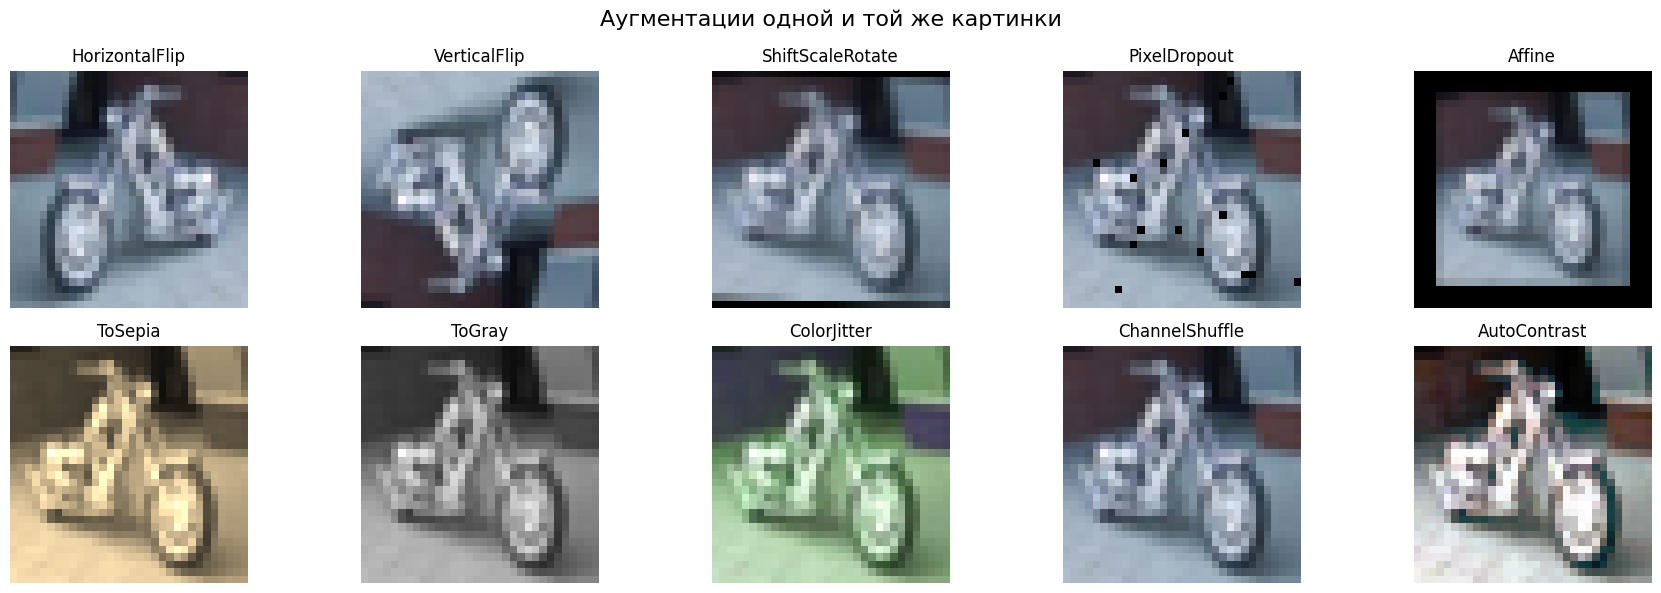

In [130]:
augmentation = [
    ("HorizontalFlip", A.HorizontalFlip(p=1.0)),
    ("VerticalFlip", A.VerticalFlip(p=1.0)),
    ("ShiftScaleRotate", A.ShiftScaleRotate(p=1.0)),
    ("PixelDropout", A.PixelDropout(p=1.0)),
    ("Affine", A.Affine(scale=(0.8, 0.8), p=1.0)),
    ("ToSepia", A.ToSepia(p=1.0)),
    ("ToGray", A.ToGray(p=1.0)),
    ("ColorJitter", A.ColorJitter(p=1.0)),
    ("ChannelShuffle", A.ChannelShuffle(p=1.0)),
    ("AutoContrast", A.AutoContrast(p=1.0)),
]

augmented_images = []
for name, aug in augmentation:
    transform = A.Compose([aug])
    aug_img = transform(image=image)["image"]
    augmented_images.append((name, aug_img))

cols = 5
rows = (len(augmented_images) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 6))
axes = axes.flatten()

for i, (name, aug_img) in enumerate(augmented_images):
    axes[i].imshow(aug_img)
    axes[i].set_title(name)
    axes[i].axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Аугментации одной и той же картинки", fontsize=16)
plt.tight_layout()
plt.show()

In [131]:
from sklearn.model_selection import train_test_split

# Собираем все (путь, метка)
all_samples = []
for label_str in os.listdir(train_path):
    class_path = os.path.join(train_path, label_str)
    label = int(label_str)
    for fname in os.listdir(class_path):
        if fname.endswith(('.jpg', '.jpeg', '.png')):
            all_samples.append((os.path.join(class_path, fname), label))

# Сплитим
train_samples, val_samples = train_test_split(all_samples, test_size=0.2, stratify=[s[1] for s in all_samples], random_state=42)


In [132]:
len(train_samples)

7608

In [133]:
len(val_samples)

1902

# Часть 3...

## Базовая модель с простыми аугментациями (повороты по вертикали и горизонтали)

In [134]:
import random
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SimpleDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = np.array(Image.open(path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

In [135]:
basic_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=mean.tolist(), std=std.tolist()),
    ToTensorV2()
])

In [136]:
val_transform = A.Compose([
    A.Normalize(mean=mean.tolist(), std=std.tolist()),
    ToTensorV2()
])

In [137]:
train_basic_ds = SimpleDataset(train_samples, transform=basic_transform)
val_ds = SimpleDataset(val_samples, transform=val_transform)

train_basic_loader = DataLoader(train_basic_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [138]:
import torch.nn as nn
import torch.nn.functional as F

class MySimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(MySimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32x32 → 32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32x32 → 32x32
        self.pool = nn.MaxPool2d(2, 2)                           # → 16x16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 16x16 → 16x16
        self.pool2 = nn.MaxPool2d(2, 2)                             # → 8x8

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # → 16x16
        x = self.pool2(F.relu(self.conv2(x)))  # → 8x8
        x = F.relu(self.conv3(x))              # → 8x8
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [139]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
device

device(type='cuda')

In [141]:
# Базовая модель
model_basic = MySimpleCNN().to(device)
optimizer_basic = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

print("Тренировка модели с простыми аугментациями:")
for epoch in range(5):
    train_loss, train_acc = train(model_basic, train_basic_loader, optimizer_basic, criterion)
    val_loss, val_acc = evaluate(model_basic, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

Тренировка модели с простыми аугментациями:
Epoch 1: Train Acc = 0.0548, Val Acc = 0.1004
Epoch 2: Train Acc = 0.1271, Val Acc = 0.1546
Epoch 3: Train Acc = 0.1790, Val Acc = 0.1940
Epoch 4: Train Acc = 0.2300, Val Acc = 0.2056
Epoch 5: Train Acc = 0.2702, Val Acc = 0.2282


## Базовая модель с продвинутыми аугментациями

In [142]:
import random
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

class MultiAugmentDataset(Dataset):
    def __init__(self, samples, augmentation_list):
        self.samples = samples
        self.augmentation_list = augmentation_list
        self.num_augs = len(augmentation_list)

    def __len__(self):
        return len(self.samples) * self.num_augs

    def __getitem__(self, idx):
        img_idx = idx // self.num_augs
        aug_idx = idx % self.num_augs

        path, label = self.samples[img_idx]
        image = np.array(Image.open(path).convert("RGB"))

        transform = self.augmentation_list[aug_idx][1]  # [1] — потому что tuple (name, transform)
        augmented = transform(image=image)
        image = augmented["image"]  # теперь это тензор [C, H, W]

        return image, label



In [143]:
augmentation_list = [
    ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()])),
    ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean.tolist(), std=std.tolist()), ToTensorV2()]))
]


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [144]:
train_fancy_ds = MultiAugmentDataset(train_samples, augmentation_list)
train_fancy_loader = DataLoader(train_fancy_ds, batch_size=64, shuffle=True)

In [145]:
# Fancy модель
model_fancy = MySimpleCNN().to(device)
optimizer_fancy = torch.optim.Adam(model_fancy.parameters(), lr=1e-3)

print("Тренировка модели с продвинутыми аугментациями:")
for epoch in range(5):
    train_loss, train_acc = train(model_fancy, train_fancy_loader, optimizer_fancy, criterion)
    val_loss, val_acc = evaluate(model_fancy, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")



Тренировка модели с продвинутыми аугментациями:
Epoch 1: Train Acc = 0.2392, Val Acc = 0.2713
Epoch 2: Train Acc = 0.5939, Val Acc = 0.2860
Epoch 3: Train Acc = 0.7517, Val Acc = 0.2760
Epoch 4: Train Acc = 0.8204, Val Acc = 0.2834
Epoch 5: Train Acc = 0.8628, Val Acc = 0.2697


In [146]:
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy

def train_with_extras(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler=None,
    num_epochs=20,
    patience=5,
    warmup_epochs=2,
    metric_name='acc',
    save_path='best_model.pth'
):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    best_val_metric = -float('inf')
    best_model_state = None
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # WARMUP
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = (epoch + 1) / warmup_epochs * 1e-3

        # --- Training ---
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # --- Validation ---
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / total
        val_acc = correct / total

        # METRIC SELECTOR
        if metric_name == 'acc':
            val_metric = val_acc
            train_metric = train_acc
        # можно будет добавить F1 или другие

        # SAVE BEST MODEL
        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            torch.save(best_model_state, save_path)
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("📉 Early stopping")
                break

        if scheduler and epoch >= warmup_epochs:
            scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)

        print(f"Epoch {epoch+1}: Train {metric_name} = {train_metric:.4f}, Val {metric_name} = {val_metric:.4f}")

    # --- Plot ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(train_losses, label='Train Loss')
    ax[0].plot(val_losses, label='Val Loss')
    ax[0].set_title("Loss Curve")
    ax[0].legend()

    ax[1].plot(train_metrics, label=f'Train {metric_name}')
    ax[1].plot(val_metrics, label=f'Val {metric_name}')
    ax[1].set_title(f"{metric_name.upper()} Curve")
    ax[1].legend()

    plt.show()

    # return best model
    model.load_state_dict(torch.load(save_path))
    return model


Epoch 1: Train acc = 0.1589, Val acc = 0.2550
Epoch 2: Train acc = 0.3820, Val acc = 0.2645
Epoch 3: Train acc = 0.6090, Val acc = 0.2750
Epoch 4: Train acc = 0.7449, Val acc = 0.2708
Epoch 5: Train acc = 0.8172, Val acc = 0.2650


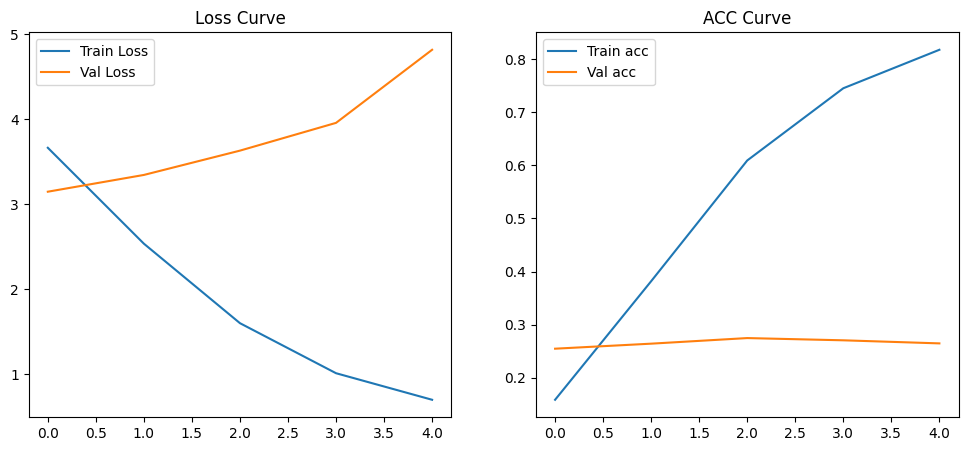

In [147]:
model_fancy = MySimpleCNN().to(device)
optimizer_fancy = torch.optim.Adam(model_fancy.parameters(), lr=1e-3)
scheduler_fancy = CosineAnnealingLR(optimizer_fancy, T_max=10)
criterion = nn.CrossEntropyLoss()

model_fancy = train_with_extras(
    model=model_fancy,
    train_loader=train_fancy_loader,
    val_loader=val_loader,
    optimizer=optimizer_fancy,
    criterion=criterion,
    scheduler=scheduler_fancy,
    num_epochs=5,
    patience=5,
    warmup_epochs=3,
    metric_name='acc',
    save_path='best_fancy_model.pth'
)


## Попробуем усложнить базовую модель

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os


# Модель
class MyImprovedCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(MyImprovedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Обучение и валидация

def train(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(dataloader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total


def plot_training(log):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(log['train_acc'], label='Train Acc')
    plt.plot(log['val_acc'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(log['train_loss'], label='Train Loss')
    plt.plot(log['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()


def train_full_pipeline(model, train_loader, val_loader, device, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    log = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_acc = 0
    patience, patience_counter = 5, 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        log['train_loss'].append(train_loss)
        log['train_acc'].append(train_acc)
        log['val_loss'].append(val_loss)
        log['val_acc'].append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    plot_training(log)
    return model

Epoch 1/10


Train Acc: 0.0442, Val Acc: 0.0904
Best model saved!
Epoch 2/10


Train Acc: 0.0788, Val Acc: 0.1677
Best model saved!
Epoch 3/10


Train Acc: 0.1107, Val Acc: 0.2382
Best model saved!
Epoch 4/10


Train Acc: 0.1498, Val Acc: 0.2776
Best model saved!
Epoch 5/10


Train Acc: 0.1776, Val Acc: 0.3081
Best model saved!
Epoch 6/10


Train Acc: 0.2007, Val Acc: 0.3239
Best model saved!
Epoch 7/10


Train Acc: 0.2246, Val Acc: 0.3517
Best model saved!
Epoch 8/10


Train Acc: 0.2395, Val Acc: 0.3675
Best model saved!
Epoch 9/10


Train Acc: 0.2520, Val Acc: 0.3654
Epoch 10/10


Train Acc: 0.2557, Val Acc: 0.3665


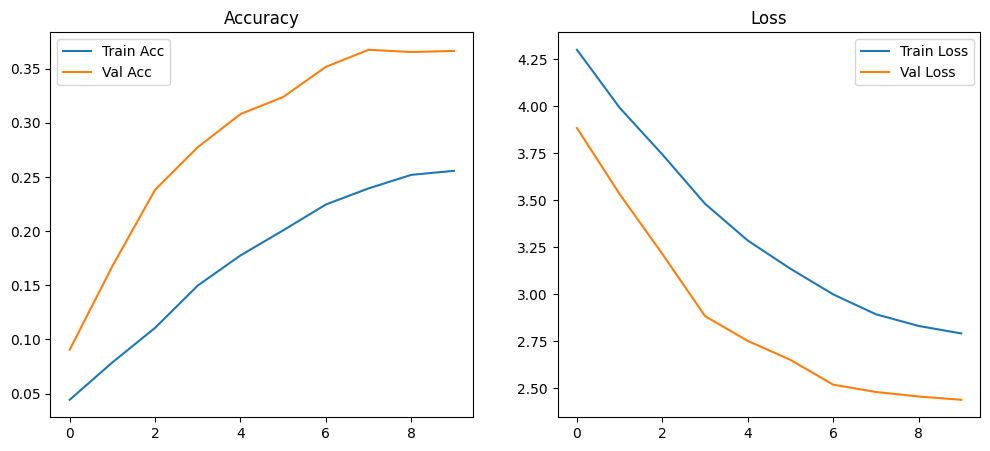

In [149]:
model = MyImprovedCNN().to(device)
model = train_full_pipeline(model, train_fancy_loader, val_loader, device)

In [150]:
# Печатаем длину датасета
print(f"Размер датасета (с учётом аугментаций): {len(train_fancy_ds)}")
print(f"Размер исходного датасета: {len(train_samples)}")

# Пример из DataLoader
for batch_idx, (data, target) in enumerate(train_fancy_loader):
    print(f"Размер батча на итерации {batch_idx + 1}: {data.size()}")
    if batch_idx == 0:  # Пример для первого батча
        break


Размер датасета (с учётом аугментаций): 76080
Размер исходного датасета: 7608
Размер батча на итерации 1: torch.Size([64, 3, 32, 32])


In [151]:
# model = MyImprovedCNN(num_classes=100).to(device)
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()


In [152]:
test_path

'/content/data/test'

In [153]:
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import os

# # Предобработка должна совпадать с той, что использовалась при обучении
# test_transform = A.Compose([
#     A.Normalize(mean=mean.tolist(), std=std.tolist()),
#     ToTensorV2()
# ])

# class TestDataset(Dataset):
#     def __init__(self, test_dir, transform):
#         self.paths = sorted([os.path.join(test_dir, fname) for fname in os.listdir(test_dir)])
#         self.transform = transform

#     def __getitem__(self, idx):
#         img_path = self.paths[idx]
#         img = Image.open(img_path).convert("RGB")
#         img = np.array(img)
#         img = self.transform(image=img)["image"]
#         return img, os.path.basename(img_path)

#     def __len__(self):
#         return len(self.paths)

# test_dir = test_path  # путь к папке с тестовыми изображениями
# test_dataset = TestDataset(test_dir, test_transform)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [154]:
# import pandas as pd

# model.eval()
# predictions = []

# with torch.no_grad():
#     for images, filenames in tqdm(test_loader):
#         images = images.to(device)
#         outputs = model(images)
#         _, predicted = outputs.max(1)
#         for fname, label in zip(filenames, predicted.cpu().numpy()):
#             img_id = int(os.path.splitext(fname)[0])  # предполагается, что имена файлов — это id (например, 0.png)
#             predictions.append((img_id, label))

# # Сортировка по id
# predictions.sort(key=lambda x: x[0])

# # Создание submission
# df = pd.DataFrame(predictions, columns=["id", "target"])
# df.to_csv("submission.csv", index=False)
# print("Submission saved as submission.csv")


# transfer learning

## densenet

In [155]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models
# from torch.utils.data import DataLoader

# # Загружаем предобученную модель DenseNet
# model_densenet = models.densenet121(pretrained=True)

# # Подгоняем последнюю слой под 100 классов
# model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, 100)

# # Перемещаем модель на нужное устройство (GPU или CPU)
# model_densenet = model_densenet.to(device)

# # Замораживаем все слои, кроме последнего
# for param in model_densenet.parameters():
#     param.requires_grad = False

# # Размораживаем параметры последнего слоя
# for param in model_densenet.classifier.parameters():
#     param.requires_grad = True

# # Определяем оптимизатор для обучения последнего слоя
# optimizer = optim.Adam(model_densenet.classifier.parameters(), lr=1e-3)

# # Критерий
# criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [156]:
# print("Тренировка модели с DenseNet:")
# for epoch in range(5):
#     train_loss, train_acc = train(model_densenet, train_fancy_loader, optimizer, scheduler, criterion, device)
#     val_loss, val_acc = evaluate(model_densenet, val_loader, criterion, device)
#     print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

# в районе 0.32

## ResNet50

In [157]:
base_path = '/content/data/'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Проверка наличия данных
print("Содержимое папки data:", os.listdir(base_path))
print("\nПример содержимого train:", os.listdir(train_path)[:5])

Содержимое папки data: ['train', 'test']

Пример содержимого train: ['66', '92', '29', '28', '86']


In [158]:
train_path

'/content/data/train'

In [159]:
def compute_mean_std(dataset_path):
    image_paths = []
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        for fname in os.listdir(class_path):
            if fname.endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))

    means = []
    stds = []

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB").resize((32, 32))
        img = np.array(img).astype(np.float32) / 255.0
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))

    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std


mean, std = compute_mean_std(train_path)
print("Mean:", mean)
print("Std:", std)


Mean: [0.5069106  0.48691878 0.4402879 ]
Std: [0.19983047 0.19736335 0.20132735]


In [160]:
from sklearn.model_selection import train_test_split

# Собираем все (путь, метка)
all_samples = []
for label_str in os.listdir(train_path):
    class_path = os.path.join(train_path, label_str)
    label = int(label_str)
    for fname in os.listdir(class_path):
        if fname.endswith(('.jpg', '.jpeg', '.png')):
            all_samples.append((os.path.join(class_path, fname), label))

# Сплитим
train_samples, val_samples = train_test_split(all_samples, test_size=0.2, stratify=[s[1] for s in all_samples], random_state=42)

In [161]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Твоя mean и std
mean = [0.50691074, 0.4869193 , 0.4402886]
std = [0.19983028, 0.19736293, 0.20132743]

# Аугментации
augmentation_list = [
    ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),

    # ("Rotate15", A.Compose([A.Rotate(limit=15, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("RandomCrop", A.Compose([A.RandomCrop(27, 27, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("ColorJitter", A.Compose([A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("CoarseDropout", A.Compose([A.CoarseDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()]))
]

# Кастомный Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]).convert("RGB"))
        image = self.transform(image=image)["image"]
        return image, self.labels[idx]

# Загрузка датасета с аугментациями
def build_augmented_dataset(base_images, base_labels):
    datasets = []
    for name, aug in augmentation_list:
        datasets.append(CustomDataset(base_images, base_labels, aug))
    return ConcatDataset(datasets)

# Модель ResNet50
class TransferResNet(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Обучение
def train(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(dataloader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

def plot_training(log):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(log['train_acc'], label='Train Acc')
    plt.plot(log['val_acc'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(log['train_loss'], label='Train Loss')
    plt.plot(log['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Полный пайплайн
from torch.optim.lr_scheduler import StepLR  # если ещё не импортировал

def train_full_pipeline(model, train_loader, val_loader, device, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Вот здесь выбираешь подходящий шедулер:
    # scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # каждые 3 эпохи делит lr на 2
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # если всё же хочешь плавное уменьшение

    log = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0
    patience, patience_counter = 5, 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_acc = train(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        log['train_loss'].append(train_loss)
        log['train_acc'].append(train_acc)
        log['val_loss'].append(val_loss)
        log['val_acc'].append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Показываем текущий learning rate
        for param_group in optimizer.param_groups:
            print(f"Current LR: {param_group['lr']}")

        # ВАЖНО: шаг шедулера
        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_resnet50.pth")
            print("Best model saved!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    plot_training(log)
    return model

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [162]:
train_paths = [s[0] for s in train_samples]
train_labels = [s[1] for s in train_samples]

val_paths = [s[0] for s in val_samples]
val_labels = [s[1] for s in val_samples]

In [163]:
# Только для train: добавляем 10 аугментаций к каждому изображению
train_augmented_dataset = build_augmented_dataset(train_paths, train_labels)

# Для валидации — без аугментаций, только нормализация
val_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])
val_dataset = CustomDataset(val_paths, val_labels, val_transform)

In [164]:
batch_size = 128  # можешь изменить

train_loader = DataLoader(train_augmented_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [165]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = TransferResNet(num_classes=100).to(device)
# model = train_full_pipeline(model, train_loader, val_loader, device, epochs=10)

In [166]:
# model = TransferResNet(num_classes=100).to(device)
# model.load_state_dict(torch.load("best_resnet50.pth"))
# model.eval()

In [186]:
test_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

In [187]:
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import os

class TestDataset(Dataset):
    def __init__(self, test_dir, transform):
        self.paths = sorted([os.path.join(test_dir, fname) for fname in os.listdir(test_dir)])
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        img = self.transform(image=img)["image"]
        return img, os.path.basename(img_path)

    def __len__(self):
        return len(self.paths)

# # Путь к папке с тестовыми изображениями
test_dataset = TestDataset(test_path, test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [169]:
# import pandas as pd
# from tqdm import tqdm

# model.eval()
# predictions = []

# with torch.no_grad():
#     for images, filenames in tqdm(test_loader):
#         images = images.to(device)
#         outputs = model(images)
#         _, predicted = outputs.max(1)
#         for fname, label in zip(filenames, predicted.cpu().numpy()):
#             img_id = int(os.path.splitext(fname)[0])  # имя файла — это id (например, "0.png" → 0)
#             predictions.append((img_id, label))

# # Сортировка по id
# predictions.sort(key=lambda x: x[0])

# # DataFrame и сохранение
# df = pd.DataFrame(predictions, columns=["id", "target"])
# df.to_csv("submission_resnet50.csv", index=False)
# print("Submission saved as submission_resnet50.csv")


## Попытка придумать комбинации аугментаций, которые повысят accuracy

In [170]:
os.listdir(train_path + '/2')[:5]

['6540.png', '6547.png', '6559.png', '6587.png', '6545.png']

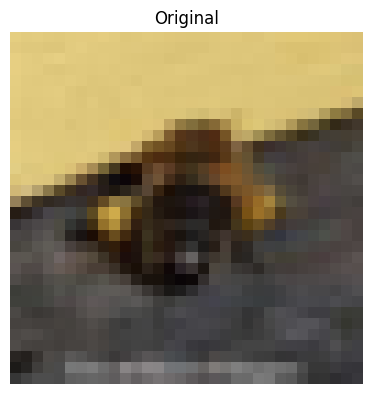

In [171]:
augmentation_list = [
    ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),

    ("Rotate15", A.Compose([A.Rotate(limit=15, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("RandomCrop", A.Compose([A.RandomCrop(27, 27, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ColorJitter", A.Compose([A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("CoarseDropout", A.Compose([A.CoarseDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()]))
]


class_id = "9"
class_dir = os.path.join(train_path, class_id)

img_name = random.choice(os.listdir(class_dir))
# img_name = '2423.png'
img_path = os.path.join(class_dir, img_name)

image = Image.open(img_path).convert("RGB")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

image = np.array(image)

## ResNet101

In [172]:
# from sklearn.model_selection import train_test_split

# # Собираем все (путь, метка)
# all_samples = []
# for label_str in os.listdir(train_path):
#     class_path = os.path.join(train_path, label_str)
#     label = int(label_str)
#     for fname in os.listdir(class_path):
#         if fname.endswith(('.jpg', '.jpeg', '.png')):
#             all_samples.append((os.path.join(class_path, fname), label))

# # Сплитим
# train_samples, val_samples = train_test_split(all_samples, test_size=0.2, stratify=[s[1] for s in all_samples], random_state=42)

In [173]:
# import torch
# import torch.nn as nn
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from torchvision import models
# from torch.utils.data import DataLoader, ConcatDataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import pandas as pd

# # Твоя mean и std
# mean = [0.50691074, 0.4869193 , 0.4402886]
# std = [0.19983028, 0.19736293, 0.20132743]

# # Аугментации
# augmentation_list = [
#     ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),

#     # ("Rotate15", A.Compose([A.Rotate(limit=15, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     # ("RandomCrop", A.Compose([A.RandomCrop(27, 27, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     # ("ColorJitter", A.Compose([A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     # ("CoarseDropout", A.Compose([A.CoarseDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()]))
# ]

# # Кастомный Dataset
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, images, labels, transform):
#         self.images = images
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = np.array(Image.open(self.images[idx]).convert("RGB"))
#         image = self.transform(image=image)["image"]
#         return image, self.labels[idx]

# # Загрузка датасета с аугментациями
# def build_augmented_dataset(base_images, base_labels):
#     datasets = []
#     for name, aug in augmentation_list:
#         datasets.append(CustomDataset(base_images, base_labels, aug))
#     return ConcatDataset(datasets)

# # Модель ResNet50
# class TransferResNet(nn.Module):
#     def __init__(self, num_classes=100):
#         super().__init__()
#         self.model = models.resnet101(pretrained=True)  # <- Вот и вся замена!
#         self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)

# # Обучение
# def train(model, dataloader, optimizer, scheduler, criterion, device):
#     model.train()
#     total_loss, correct, total = 0, 0, 0
#     for images, labels in tqdm(dataloader, leave=False):
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * labels.size(0)
#         _, predicted = outputs.max(1)
#         correct += predicted.eq(labels).sum().item()
#         total += labels.size(0)
#     scheduler.step()
#     return total_loss / total, correct / total

# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss, correct, total = 0, 0, 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * labels.size(0)
#             _, predicted = outputs.max(1)
#             correct += predicted.eq(labels).sum().item()
#             total += labels.size(0)
#     return total_loss / total, correct / total

# def plot_training(log):
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(log['train_acc'], label='Train Acc')
#     plt.plot(log['val_acc'], label='Val Acc')
#     plt.legend()
#     plt.title('Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(log['train_loss'], label='Train Loss')
#     plt.plot(log['val_loss'], label='Val Loss')
#     plt.legend()
#     plt.title('Loss')
#     plt.show()

# # Полный пайплайн
# from torch.optim.lr_scheduler import StepLR  # если ещё не импортировал

# def train_full_pipeline(model, train_loader, val_loader, device, epochs=10):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#     # Вот здесь выбираешь подходящий шедулер:
#     # scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # каждые 3 эпохи делит lr на 2
#     scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # если всё же хочешь плавное уменьшение

#     log = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
#     best_acc = 0
#     patience, patience_counter = 5, 0

#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}/{epochs}")

#         train_loss, train_acc = train(model, train_loader, optimizer, scheduler, criterion, device)
#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)

#         log['train_loss'].append(train_loss)
#         log['train_acc'].append(train_acc)
#         log['val_loss'].append(val_loss)
#         log['val_acc'].append(val_acc)

#         print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

#         # Показываем текущий learning rate
#         for param_group in optimizer.param_groups:
#             print(f"Current LR: {param_group['lr']}")

#         # ВАЖНО: шаг шедулера
#         scheduler.step()

#         if val_acc > best_acc:
#             best_acc = val_acc
#             patience_counter = 0
#             torch.save(model.state_dict(), "best_resnet101.pth")
#             print("Best model saved!")
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#     plot_training(log)
#     return model

# train_paths = [s[0] for s in train_samples]
# train_labels = [s[1] for s in train_samples]

# val_paths = [s[0] for s in val_samples]
# val_labels = [s[1] for s in val_samples]

# # Только для train: добавляем 10 аугментаций к каждому изображению
# train_augmented_dataset = build_augmented_dataset(train_paths, train_labels)

# # Для валидации — без аугментаций, только нормализация
# val_transform = A.Compose([
#     A.Normalize(mean=mean, std=std),
#     ToTensorV2()
# ])
# val_dataset = CustomDataset(val_paths, val_labels, val_transform)

# batch_size = 128  # можешь изменить

# train_loader = DataLoader(train_augmented_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [174]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = TransferResNet(num_classes=100).to(device)
# model = train_full_pipeline(model, train_loader, val_loader, device, epochs=10)

## EfficientB0

In [175]:
# import torch
# import torch.nn as nn
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from torchvision import models
# from torch.utils.data import DataLoader, ConcatDataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import pandas as pd

# # Твоя mean и std
# mean = [0.50691074, 0.4869193 , 0.4402886]
# std = [0.19983028, 0.19736293, 0.20132743]

# # Аугментации
# augmentation_list = [
#     ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),

#     # ("Rotate15", A.Compose([A.Rotate(limit=15, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     # ("RandomCrop", A.Compose([A.RandomCrop(27, 27, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     # ("ColorJitter", A.Compose([A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
#     # ("CoarseDropout", A.Compose([A.CoarseDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()]))
# ]

# # Кастомный Dataset
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, images, labels, transform):
#         self.images = images
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = np.array(Image.open(self.images[idx]).convert("RGB"))
#         image = self.transform(image=image)["image"]
#         return image, self.labels[idx]

# # Загрузка датасета с аугментациями
# def build_augmented_dataset(base_images, base_labels):
#     datasets = []
#     for name, aug in augmentation_list:
#         datasets.append(CustomDataset(base_images, base_labels, aug))
#     return ConcatDataset(datasets)

# from torchvision import models
# import torch.nn as nn

# class TransferResNet(nn.Module):  # Имя класса остаётся прежним
#     def __init__(self, num_classes=100):
#         super().__init__()
#         # Загружаем EfficientNet-B0 вместо ResNet
#         self.model = models.efficientnet_b0(pretrained=True)

#         # Адаптируем первый слой для изображений 32x32
#         self.model.features[0][0] = nn.Conv2d(
#             3, 32, kernel_size=3, stride=1, padding=1, bias=False
#         )
#         self.model.features[0][1] = nn.Identity()  # Убираем BatchNorm для упрощения

#         # Заменяем классификатор
#         self.model.classifier[1] = nn.Linear(
#             self.model.classifier[1].in_features,
#             num_classes
#         )

#     def forward(self, x):
#         return self.model(x)

# # Обучение
# def train(model, dataloader, optimizer, scheduler, criterion, device):
#     model.train()
#     total_loss, correct, total = 0, 0, 0
#     for images, labels in tqdm(dataloader, leave=False):
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * labels.size(0)
#         _, predicted = outputs.max(1)
#         correct += predicted.eq(labels).sum().item()
#         total += labels.size(0)
#     scheduler.step()
#     return total_loss / total, correct / total

# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss, correct, total = 0, 0, 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * labels.size(0)
#             _, predicted = outputs.max(1)
#             correct += predicted.eq(labels).sum().item()
#             total += labels.size(0)
#     return total_loss / total, correct / total

# def plot_training(log):
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(log['train_acc'], label='Train Acc')
#     plt.plot(log['val_acc'], label='Val Acc')
#     plt.legend()
#     plt.title('Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(log['train_loss'], label='Train Loss')
#     plt.plot(log['val_loss'], label='Val Loss')
#     plt.legend()
#     plt.title('Loss')
#     plt.show()

# # Полный пайплайн
# from torch.optim.lr_scheduler import StepLR  # если ещё не импортировал

# def train_full_pipeline(model, train_loader, val_loader, device, epochs=10):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#     # Вот здесь выбираешь подходящий шедулер:
#     # scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # каждые 3 эпохи делит lr на 2
#     scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # если всё же хочешь плавное уменьшение

#     log = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
#     best_acc = 0
#     patience, patience_counter = 5, 0

#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}/{epochs}")

#         train_loss, train_acc = train(model, train_loader, optimizer, scheduler, criterion, device)
#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)

#         log['train_loss'].append(train_loss)
#         log['train_acc'].append(train_acc)
#         log['val_loss'].append(val_loss)
#         log['val_acc'].append(val_acc)

#         print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

#         # Показываем текущий learning rate
#         for param_group in optimizer.param_groups:
#             print(f"Current LR: {param_group['lr']}")

#         # ВАЖНО: шаг шедулера
#         scheduler.step()

#         if val_acc > best_acc:
#             best_acc = val_acc
#             patience_counter = 0
#             torch.save(model.state_dict(), "best_resnet101.pth")
#             print("Best model saved!")
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#     plot_training(log)
#     return model

# train_paths = [s[0] for s in train_samples]
# train_labels = [s[1] for s in train_samples]

# val_paths = [s[0] for s in val_samples]
# val_labels = [s[1] for s in val_samples]

# # Только для train: добавляем 10 аугментаций к каждому изображению
# train_augmented_dataset = build_augmented_dataset(train_paths, train_labels)

# # Для валидации — без аугментаций, только нормализация
# val_transform = A.Compose([
#     A.Normalize(mean=mean, std=std),
#     ToTensorV2()
# ])
# val_dataset = CustomDataset(val_paths, val_labels, val_transform)

# batch_size = 128  # можешь изменить

# train_loader = DataLoader(train_augmented_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [176]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = TransferResNet(num_classes=100).to(device)
# model = train_full_pipeline(model, train_loader, val_loader, device, epochs=10)

In [182]:
# test_transform = A.Compose([
#     A.Normalize(mean=mean, std=std),
#     ToTensorV2()
# ])

# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import os

class TestDataset(Dataset):
    def __init__(self, test_dir, transform):
        self.paths = sorted([os.path.join(test_dir, fname) for fname in os.listdir(test_dir)])
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        img = self.transform(image=img)["image"]
        return img, os.path.basename(img_path)

    def __len__(self):
        return len(self.paths)

# # Путь к папке с тестовыми изображениями
# test_dataset = TestDataset(test_path, test_transform)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# import pandas as pd
# from tqdm import tqdm

# model.eval()
# predictions = []

# with torch.no_grad():
#     for images, filenames in tqdm(test_loader):
#         images = images.to(device)
#         outputs = model(images)
#         _, predicted = outputs.max(1)
#         for fname, label in zip(filenames, predicted.cpu().numpy()):
#             img_id = int(os.path.splitext(fname)[0])  # имя файла — это id (например, "0.png" → 0)
#             predictions.append((img_id, label))

# # Сортировка по id
# predictions.sort(key=lambda x: x[0])

# # DataFrame и сохранение
# df = pd.DataFrame(predictions, columns=["id", "target"])
# df.to_csv("submission_efficientB0.csv", index=False)
# print("Submission saved as submission_efficientB0.csv")

# Все, что ниже (кроме cGAN) - для выбивания скора на кагле.

## EfficientNet-V2-S

In [178]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Твоя mean и std
mean = [0.50691074, 0.4869193 , 0.4402886]
std = [0.19983028, 0.19736293, 0.20132743]

# Аугментации
augmentation_list = [
    ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),

    # # Комбинации аугментаций
    # ("HorizontalVerticalFlip", A.Compose([
    #     A.HorizontalFlip(p=1.0),
    #     A.VerticalFlip(p=1.0),
    #     A.Normalize(mean=mean, std=std),
    #     ToTensorV2()
    # ])),

    # ("HorizontalPixelDropout", A.Compose([
    #     A.HorizontalFlip(p=1.0),
    #     A.PixelDropout(p=1.0),
    #     A.Normalize(mean=mean, std=std),
    #     ToTensorV2()
    # ])),

    # ("AffinePixelDropout", A.Compose([
    #     A.Affine(scale=(0.8, 0.8), p=1.0),
    #     A.PixelDropout(p=1.0),
    #     A.Normalize(mean=mean, std=std),
    #     ToTensorV2()
    # ])),

    # ("ToSepiaPixelDropout", A.Compose([
    #     A.ToSepia(p=1.0),
    #     A.PixelDropout(p=1.0),
    #     A.Normalize(mean=mean, std=std),
    #     ToTensorV2()
    # ])),

    # ("Rotate15", A.Compose([A.Rotate(limit=15, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("RandomCrop", A.Compose([A.RandomCrop(27, 27, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("ColorJitter", A.Compose([A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("CoarseDropout", A.Compose([A.CoarseDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()]))
]

# Кастомный Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]).convert("RGB"))
        image = self.transform(image=image)["image"]
        return image, self.labels[idx]

# Загрузка датасета с аугментациями
def build_augmented_dataset(base_images, base_labels):
    datasets = []
    for name, aug in augmentation_list:
        datasets.append(CustomDataset(base_images, base_labels, aug))
    return ConcatDataset(datasets)

from torchvision import models
import torch.nn as nn

class TransferResNet(nn.Module):  # Имя класса остаётся прежним
    def __init__(self, num_classes=100):
        super().__init__()
        # Загружаем EfficientNet-V2-S вместо ResNet
        self.model = models.efficientnet_v2_s(pretrained=True)

        # Адаптируем первый слой для изображений 32x32
        self.model.features[0][0] = nn.Conv2d(
            3, 24,  # У EfficientNet-V2-S в первом слое 24 канала
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.model.features[0][1] = nn.Identity()  # Убираем BatchNorm

        # Заменяем классификатор
        self.model.classifier[1] = nn.Linear(
            self.model.classifier[1].in_features,
            num_classes
        )

    def forward(self, x):
        return self.model(x)

# Обучение
def train(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(dataloader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

def plot_training(log):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(log['train_acc'], label='Train Acc')
    plt.plot(log['val_acc'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(log['train_loss'], label='Train Loss')
    plt.plot(log['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Полный пайплайн
from torch.optim.lr_scheduler import StepLR  # если ещё не импортировал

def train_full_pipeline(model, train_loader, val_loader, device, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Вот здесь выбираешь подходящий шедулер:
    scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # если всё же хочешь плавное уменьшение

    log = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0
    patience, patience_counter = 5, 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_acc = train(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        log['train_loss'].append(train_loss)
        log['train_acc'].append(train_acc)
        log['val_loss'].append(val_loss)
        log['val_acc'].append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Показываем текущий learning rate
        for param_group in optimizer.param_groups:
            print(f"Current LR: {param_group['lr']}")

        # ВАЖНО: шаг шедулера
        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "efficientnet_v2_s.pth")
            print("Best model saved!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    plot_training(log)
    return model

train_paths = [s[0] for s in train_samples]
train_labels = [s[1] for s in train_samples]

val_paths = [s[0] for s in val_samples]
val_labels = [s[1] for s in val_samples]

# Только для train: добавляем 10 аугментаций к каждому изображению
train_augmented_dataset = build_augmented_dataset(train_paths, train_labels)

# Для валидации — без аугментаций, только нормализация
val_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])
val_dataset = CustomDataset(val_paths, val_labels, val_transform)

batch_size = 128  # можешь изменить

train_loader = DataLoader(train_augmented_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8


Train Acc: 0.5009, Val Acc: 0.5442
Current LR: 0.001
Best model saved!
Epoch 2/8


Train Acc: 0.9085, Val Acc: 0.6109
Current LR: 0.0005
Best model saved!
Epoch 3/8


Train Acc: 0.9768, Val Acc: 0.6146
Current LR: 0.00025
Best model saved!
Epoch 4/8


Train Acc: 0.9900, Val Acc: 0.6420
Current LR: 0.000125
Best model saved!
Epoch 5/8


Train Acc: 0.9940, Val Acc: 0.6393
Current LR: 6.25e-05
Epoch 6/8


Train Acc: 0.9960, Val Acc: 0.6388
Current LR: 3.125e-05
Epoch 7/8


Train Acc: 0.9963, Val Acc: 0.6388
Current LR: 1.5625e-05
Epoch 8/8


Train Acc: 0.9967, Val Acc: 0.6404
Current LR: 7.8125e-06


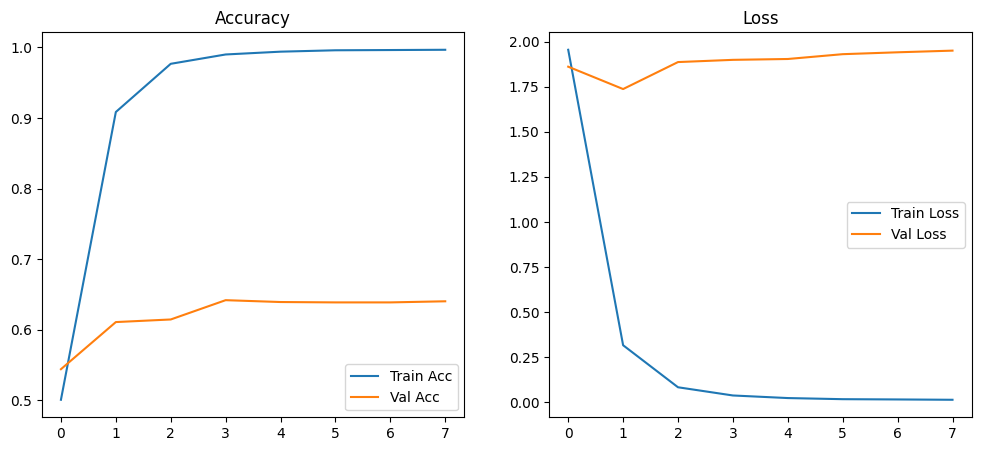

In [179]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransferResNet(num_classes=100).to(device)
model = train_full_pipeline(model, train_loader, val_loader, device, epochs=8)

In [188]:
# Загружаем лучшую модель
model.load_state_dict(torch.load("efficientnet_v2_s.pth"))
model.to(device)
model.eval()

# Прогнозируем
predictions = []
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        for fname, label in zip(filenames, predicted.cpu().numpy()):
            img_id = int(os.path.splitext(fname)[0])
            predictions.append((img_id, label))

# Сортируем по id
predictions.sort(key=lambda x: x[0])

# Формируем .csv
df = pd.DataFrame(predictions, columns=["id", "target"])
df.to_csv("submission_efficientV2S.csv", index=False)
print("Submission saved as submission_efficientV2S.csv")


100%|██████████| 61/61 [00:03<00:00, 17.34it/s]

Submission saved as submission_efficientV2S.csv


## cGAN

In [189]:
train_path

'/content/data/train'

In [190]:
test_path

'/content/data/test'

In [191]:
base_path = '/content/data/'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Проверка наличия данных
print("Содержимое папки data:", os.listdir(base_path))
print("\nПример содержимого train:", os.listdir(train_path)[:5])

Содержимое папки data: ['train', 'test']

Пример содержимого train: ['66', '92', '29', '28', '86']


In [192]:
def compute_mean_std(dataset_path):
    image_paths = []
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        for fname in os.listdir(class_path):
            if fname.endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))

    means = []
    stds = []

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB").resize((32, 32))
        img = np.array(img).astype(np.float32) / 255.0
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))

    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std


mean, std = compute_mean_std(train_path)
print("Mean:", mean)
print("Std:", std)


Mean: [0.5069106  0.48691878 0.4402879 ]
Std: [0.19983047 0.19736335 0.20132735]


In [193]:
from sklearn.model_selection import train_test_split

# Собираем все (путь, метка)
all_samples = []
for label_str in os.listdir(train_path):
    class_path = os.path.join(train_path, label_str)
    label = int(label_str)
    for fname in os.listdir(class_path):
        if fname.endswith(('.jpg', '.jpeg', '.png')):
            all_samples.append((os.path.join(class_path, fname), label))

# Сплитим
train_samples, val_samples = train_test_split(all_samples, test_size=0.2, stratify=[s[1] for s in all_samples], random_state=42)

In [194]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Твоя mean и std
mean = [0.50691074, 0.4869193 , 0.4402886]
std = [0.19983028, 0.19736293, 0.20132743]

# Аугментации
augmentation_list = [
    ("HorizontalFlip", A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("VerticalFlip", A.Compose([A.VerticalFlip(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ShiftScaleRotate", A.Compose([A.ShiftScaleRotate(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("PixelDropout", A.Compose([A.PixelDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("Affine", A.Compose([A.Affine(scale=(0.8, 0.8), p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToSepia", A.Compose([A.ToSepia(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ToGray", A.Compose([A.ToGray(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ColorJitter", A.Compose([A.ColorJitter(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("ChannelShuffle", A.Compose([A.ChannelShuffle(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    ("AutoContrast", A.Compose([A.AutoContrast(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),

    # ("Rotate15", A.Compose([A.Rotate(limit=15, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("RandomCrop", A.Compose([A.RandomCrop(27, 27, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("ColorJitter", A.Compose([A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()])),
    # ("CoarseDropout", A.Compose([A.CoarseDropout(p=1.0), A.Normalize(mean=mean, std=std), ToTensorV2()]))
]

# Кастомный Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]).convert("RGB"))
        image = self.transform(image=image)["image"]
        return image, self.labels[idx]

# Загрузка датасета с аугментациями
def build_augmented_dataset(base_images, base_labels):
    datasets = []
    for name, aug in augmentation_list:
        datasets.append(CustomDataset(base_images, base_labels, aug))
    return ConcatDataset(datasets)

train_paths = [s[0] for s in train_samples]
train_labels = [s[1] for s in train_samples]

val_paths = [s[0] for s in val_samples]
val_labels = [s[1] for s in val_samples]


# Только для train: добавляем 10 аугментаций к каждому изображению
train_augmented_dataset = build_augmented_dataset(train_paths, train_labels)

# Для валидации — без аугментаций, только нормализация
val_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])
val_dataset = CustomDataset(val_paths, val_labels, val_transform)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np
from tqdm import tqdm


class Generator(nn.Module):
    def __init__(self, z_dim, class_dim, img_shape):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(100, class_dim)
        self.model = nn.Sequential(
            nn.Linear(z_dim + class_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        gen_input = torch.cat((noise, label_embedding), -1)
        img = self.model(gen_input)
        return img.view(img.size(0), *self.img_shape)

class Discriminator(nn.Module):
    def __init__(self, class_dim, img_shape):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Embedding(100, class_dim)
        self.model = nn.Sequential(
            nn.Linear(np.prod(img_shape) + class_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.img_shape = img_shape

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        d_in = torch.cat((img.view(img.size(0), -1), label_embedding), -1)
        validity = self.model(d_in)
        return validity


transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)


z_dim = 100
class_dim = 10
img_shape = (3, 32, 32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(z_dim, class_dim, img_shape).to(device)
discriminator = Discriminator(class_dim, img_shape).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [195]:
epochs = 5
for epoch in range(epochs):
    for imgs, labels in tqdm(train_loader):
        batch_size = imgs.size(0)
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)
        z = torch.randn(batch_size, z_dim).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        gen_imgs = generator(z, labels)
        validity = discriminator(gen_imgs, labels)
        g_loss = adversarial_loss(validity, real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_imgs, labels)
        fake_validity = discriminator(gen_imgs.detach(), labels)
        d_loss = (adversarial_loss(real_validity, real) + adversarial_loss(fake_validity, fake)) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[{epoch+1}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")


100%|██████████| 75/75 [00:05<00:00, 13.33it/s]


[1/5] D loss: 0.0872, G loss: 3.0549


100%|██████████| 75/75 [00:06<00:00, 11.65it/s]


[2/5] D loss: 0.1109, G loss: 2.4480


100%|██████████| 75/75 [00:05<00:00, 14.15it/s]


[3/5] D loss: 0.0576, G loss: 2.7356


100%|██████████| 75/75 [00:03<00:00, 19.41it/s]


[4/5] D loss: 0.0516, G loss: 2.7122


100%|██████████| 75/75 [00:03<00:00, 19.99it/s]

[5/5] D loss: 0.0186, G loss: 3.6773


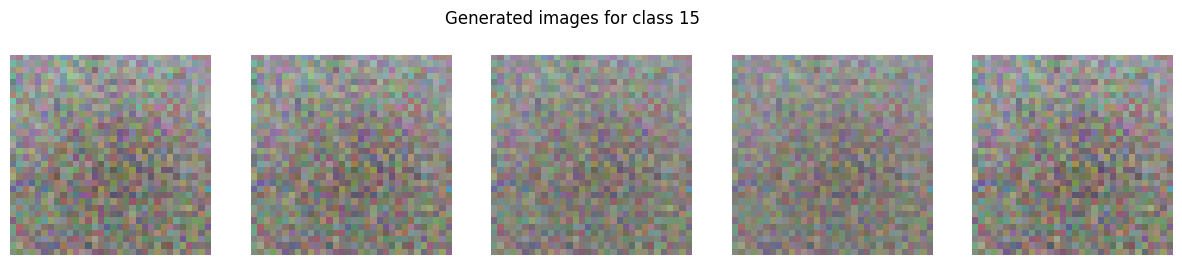

In [196]:
generator.eval()
os.makedirs("cgan_generated", exist_ok=True)

for label in range(100):
    label_dir = os.path.join("cgan_generated", str(label))
    os.makedirs(label_dir, exist_ok=True)
    for i in range(5):  # по 50 картинок на класс
        z = torch.randn(1, z_dim).to(device)
        label_tensor = torch.tensor([label]).to(device)
        gen_img = generator(z, label_tensor)
        save_image(gen_img * 0.5 + 0.5, os.path.join(label_dir, f"{i}.png"))


from PIL import Image
import matplotlib.pyplot as plt
import os

# Путь к 5 картинкам класса 15
folder = "cgan_generated/1"
files = os.listdir(folder)[:5]

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, fname in enumerate(files):
    img = Image.open(os.path.join(folder, fname))
    axs[i].imshow(img)
    axs[i].axis('off')
plt.suptitle("Generated images for class 15")
plt.show()


In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np
from tqdm import tqdm

# Улучшенный генератор с трансформерами
class Generator(nn.Module):
    def __init__(self, z_dim, class_dim, img_channels):
        super(Generator, self).__init__()

        self.label_embed = nn.Embedding(100, class_dim)

        self.init_size = 32 // 4  # Начальный размер для апсемплинга
        self.l1 = nn.Linear(z_dim + class_dim, 128 * self.init_size**2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Конкатенируем шум и метки класса
        label_embedding = self.label_embed(labels)
        gen_input = torch.cat((noise, label_embedding), -1)

        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Улучшенный дискриминатор
class Discriminator(nn.Module):
    def __init__(self, class_dim, img_channels):
        super(Discriminator, self).__init__()

        self.label_embed = nn.Embedding(100, class_dim)
        self.img_size = 32

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            block.extend([
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ])
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(img_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # Вычисление размера фичи-мапы после конволюций
        ds_size = self.img_size // 2**4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size**2 + class_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)

        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        out = torch.cat([out, label_embedding], 1)
        validity = self.adv_layer(out)

        return validity

# Параметры
z_dim = 100
class_dim = 50  # Увеличим размерность эмбеддинга классов
img_channels = 3
img_size = 32
batch_size = 128
lr = 0.0002
b1 = 0.5
b2 = 0.999
epochs = 20  # Увеличим количество эпох

# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim, class_dim, img_channels).to(device)
discriminator = Discriminator(class_dim, img_channels).to(device)

# Функция потерь
adversarial_loss = nn.BCELoss()

# Оптимизаторы
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Трансформы
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Датасет и загрузчик
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

import os

# Создаем папку для сохранения изображений
os.makedirs("images", exist_ok=True)

# Обучение
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(tqdm(train_loader)):

        batch_size = imgs.shape[0]
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Обучение генератора
        # ---------------------
        optimizer_G.zero_grad()

        # Генерируем шум и изображения
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = generator(z, labels)

        # Потеря генератора
        validity = discriminator(gen_imgs, labels)
        g_loss = adversarial_loss(validity, real)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Обучение дискриминатора
        # ---------------------
        optimizer_D.zero_grad()

        # Потеря на реальных изображениях
        real_validity = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_validity, real)

        # Потеря на фейковых изображениях
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = generator(z, labels)
        fake_validity = discriminator(gen_imgs.detach(), labels)
        d_fake_loss = adversarial_loss(fake_validity, fake)

        # Общая потеря
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Логирование
        batches_done = epoch * len(train_loader) + i
        if batches_done % 100 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Сохраняем примеры изображений
    if epoch % 5 == 0:
        with torch.no_grad():
            # Генерируем примеры для каждого класса
            z = torch.randn(10, z_dim).to(device)
            labels = torch.arange(0, 10).to(device)
            gen_imgs = generator(z, labels)

            # Сохраняем
            save_image(gen_imgs.data, f"images/epoch_{epoch}.png", nrow=5, normalize=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  4%|▍         | 3/75 [00:00<00:10,  6.69it/s]

[Epoch 0/20] [Batch 0/75] [D loss: 0.6975] [G loss: 0.7105]


 37%|███▋      | 28/75 [00:01<00:02, 16.53it/s]

[Epoch 1/20] [Batch 25/75] [D loss: 0.6994] [G loss: 0.6786]


 72%|███████▏  | 54/75 [00:03<00:01, 17.20it/s]

[Epoch 2/20] [Batch 50/75] [D loss: 0.6911] [G loss: 0.7190]


  4%|▍         | 3/75 [00:00<00:10,  6.70it/s]

[Epoch 4/20] [Batch 0/75] [D loss: 0.6958] [G loss: 0.6962]


 37%|███▋      | 28/75 [00:01<00:02, 19.22it/s]

[Epoch 5/20] [Batch 25/75] [D loss: 0.6933] [G loss: 0.6968]


 72%|███████▏  | 54/75 [00:04<00:01, 16.72it/s]

[Epoch 6/20] [Batch 50/75] [D loss: 0.6939] [G loss: 0.6936]


  4%|▍         | 3/75 [00:00<00:10,  7.13it/s]

[Epoch 8/20] [Batch 0/75] [D loss: 0.6956] [G loss: 0.6897]


 39%|███▊      | 29/75 [00:02<00:02, 15.76it/s]

[Epoch 9/20] [Batch 25/75] [D loss: 0.6943] [G loss: 0.6953]


 72%|███████▏  | 54/75 [00:03<00:01, 18.36it/s]

[Epoch 10/20] [Batch 50/75] [D loss: 0.6916] [G loss: 0.7072]


  4%|▍         | 3/75 [00:00<00:14,  4.88it/s]

[Epoch 12/20] [Batch 0/75] [D loss: 0.6927] [G loss: 0.7014]


 39%|███▊      | 29/75 [00:01<00:02, 17.65it/s]

[Epoch 13/20] [Batch 25/75] [D loss: 0.6928] [G loss: 0.7064]


 71%|███████   | 53/75 [00:04<00:01, 11.10it/s]

[Epoch 14/20] [Batch 50/75] [D loss: 0.6952] [G loss: 0.6897]


  4%|▍         | 3/75 [00:00<00:11,  6.29it/s]

[Epoch 16/20] [Batch 0/75] [D loss: 0.6930] [G loss: 0.6970]


 35%|███▍      | 26/75 [00:03<00:09,  5.43it/s]

[Epoch 17/20] [Batch 25/75] [D loss: 0.6933] [G loss: 0.6934]


 72%|███████▏  | 54/75 [00:03<00:01, 17.28it/s]

[Epoch 18/20] [Batch 50/75] [D loss: 0.6934] [G loss: 0.6951]


100%|██████████| 75/75 [00:05<00:00, 13.33it/s]


Epoch: 0


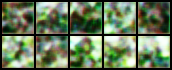

Epoch: 10


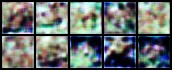

Epoch: 15


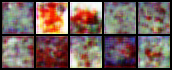

Epoch: 5


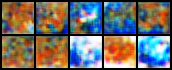

In [198]:
from IPython.display import Image, display
import os

# Показываем все сгенерированные изображения
for img_file in sorted(os.listdir("images")):
    if img_file.endswith(".png"):
        print(f"Epoch: {img_file.split('_')[1].split('.')[0]}")
        display(Image(f"images/{img_file}"))

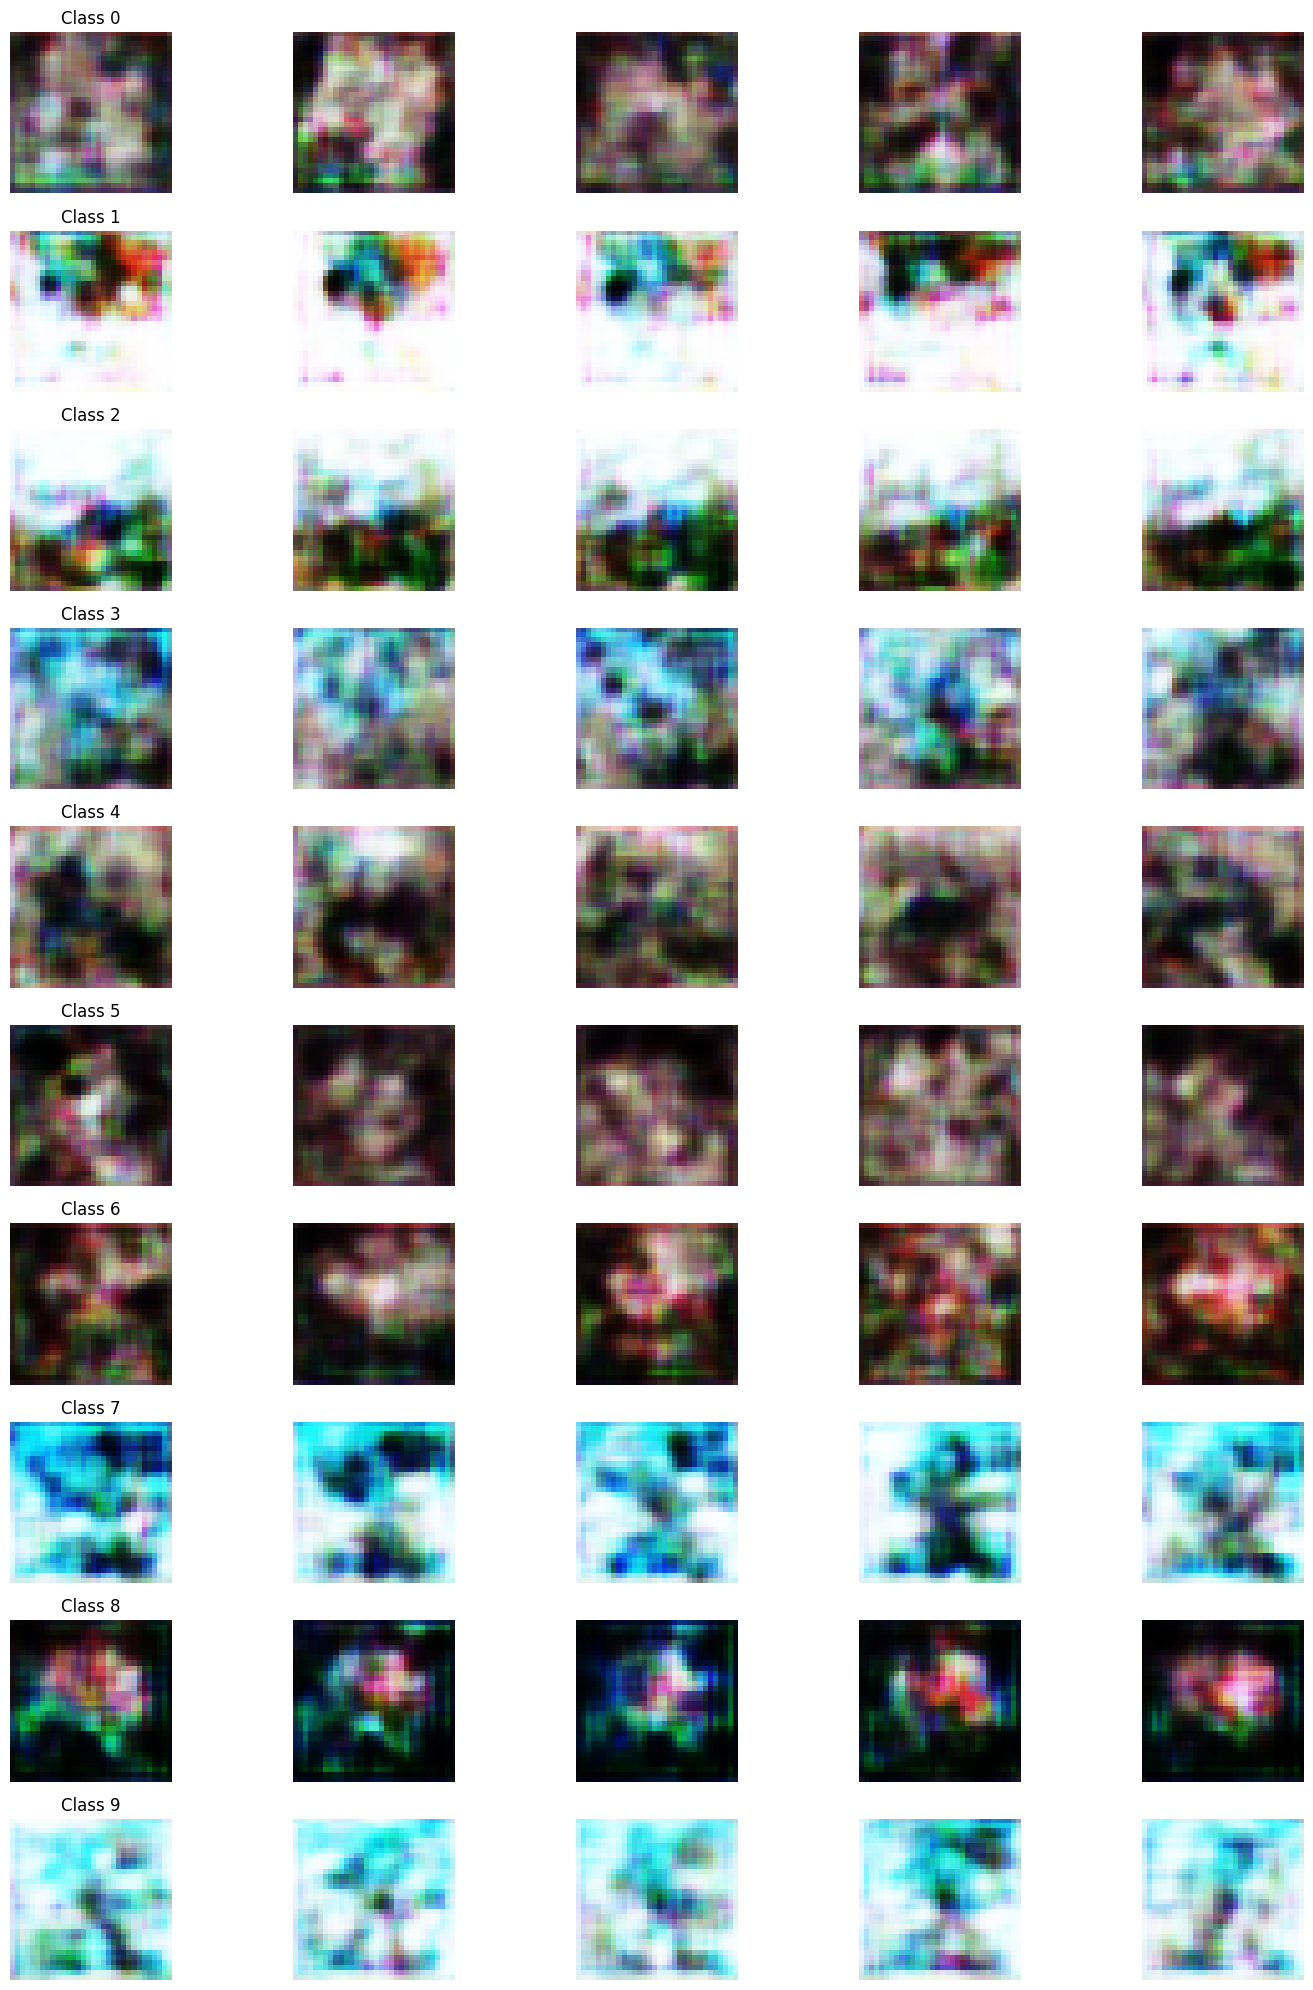

In [199]:
import matplotlib.pyplot as plt
import numpy as np

# Генерируем новые примеры
n_classes = 10  # Количество классов
n_examples = 5   # Примеров на класс

generator.eval()  # Переводим генератор в режим оценки

with torch.no_grad():
    # Создаем сетку для визуализации
    fig, axes = plt.subplots(n_classes, n_examples, figsize=(15, 20))

    for class_idx in range(n_classes):
        # Генерируем для каждого класса
        z = torch.randn(n_examples, z_dim).to(device)
        labels = torch.full((n_examples,), class_idx, dtype=torch.long).to(device)
        gen_imgs = generator(z, labels).cpu()

        for example_idx in range(n_examples):
            img = gen_imgs[example_idx].permute(1, 2, 0).numpy()
            img = (img + 1) / 2  # Денормализация [0, 1]

            ax = axes[class_idx, example_idx]
            ax.imshow(img)
            ax.axis("off")

            if example_idx == 0:
                ax.set_title(f"Class {class_idx}")

    plt.tight_layout()
    plt.show()